# Working with samplesets

First, we need a model to submit to the CQM Hybrid Solver through Leap.<br>
For this example, we will submit a CQM based on a Quadratic Assignment Problem.

### Build a CQM

In [49]:
from dimod import ConstrainedQuadraticModel
import random

# Set size parameter. Model will have n^2 variables.
n=2

# Instantiate CQM and add grid of variables
cqm = ConstrainedQuadraticModel()
cqm.add_variables('BINARY', [(a,b) for a in range(n) for b in range(n)])

# Add psuedorandom dense objective.
random.seed(1)
cqm.set_objective([(v,w,random.randint(5,20)) for v in cqm.variables for w in cqm.variables])

# Add assignment constraint.
for i in range(n):
    cqm.add_constraint_from_iterable([((i,j), 1) for j in range(n)], '==', rhs=1, label=f'({i},*)')
    cqm.add_constraint_from_iterable([((j,i), 1) for j in range(n)], '==', rhs=1, label=f'(*, {i})')
    
print('Number of Variables:', len(cqm.variables))

Number of Variables: 4 4


### Get a sampleset by submitting the CQM to the solver

In [50]:
from dwave.system import LeapHybridCQMSampler

cqm_sampler = LeapHybridCQMSampler()

sampleset = cqm_sampler.sample_cqm(cqm, time_limit=5)

#### Raw samplesets are best viewed with a print call

In [51]:
print(sampleset)

    (0, 0) (0, 1) (1, 0) (1, 1) energy num_oc. is_sat. is_fea.
96     1.0    0.0    0.0    0.0    9.0       1 arra...   False
97     1.0    0.0    0.0    0.0    9.0       1 arra...   False
98     1.0    0.0    0.0    0.0    9.0       1 arra...   False
99     1.0    0.0    0.0    0.0    9.0       1 arra...   False
100    1.0    0.0    0.0    0.0    9.0       1 arra...   False
101    1.0    0.0    0.0    0.0    9.0       1 arra...   False
102    1.0    0.0    0.0    0.0    9.0       1 arra...   False
103    1.0    0.0    0.0    0.0    9.0       1 arra...   False
104    1.0    0.0    0.0    0.0    9.0       1 arra...   False
105    0.0    0.0    0.0    1.0   19.0       1 arra...   False
106    0.0    0.0    0.0    1.0   19.0       1 arra...   False
107    0.0    1.0    0.0    0.0   19.0       1 arra...   False
108    0.0    1.0    0.0    0.0   19.0       1 arra...   False
109    0.0    0.0    0.0    1.0   19.0       1 arra...   False
110    0.0    0.0    0.0    1.0   19.0       1 arra... 

#### Get some useful metrics for potential plots you might want to generate!<br>Reported times are measured in microseconds.

In [52]:
for key, value in sampleset.info.items():
    print(key, value,'\n')

constraint_labels ['(*, 1)', '(1,*)', '(0,*)', '(*, 0)'] 

qpu_access_time 31723 

charge_time 5000000 

run_time 5104433 

problem_id 1b0c4a64-7136-4b6c-a594-eecebe7b1866 



#### What about the solution quality?<br>We can look at the best solution in general (maybe infeasible) or filter for the best feasible solution found.

In [56]:
# Best solution (objective minimized)
print(sampleset.first, "\n")

print("Sample energy: ", sampleset.first.energy, "\n")

print("Are all constraints satisfied? ", sampleset.first.is_feasible)

Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0, num_occurrences=1, is_satisfied=array([False, False,  True,  True]), is_feasible=False) 

Sample energy:  9.0 

Are all constraints satisfied?  False


#### Let's filter for the best feasible sample - where all hard constraints are satisfied.

In [64]:
feasible_sampleset = sampleset.filter(lambda d:d.is_feasible)

print('# Samples:', len(sampleset))
print('# Feasible:', len(feasible_sampleset), "\n")

print(feasible_sampleset)

# Samples: 120
# Feasible: 96
   (0, 0) (0, 1) (1, 0) (1, 1) energy num_oc. is_sat. is_fea.
0     1.0    0.0    0.0    1.0   53.0       1 arra...    True
1     1.0    0.0    0.0    1.0   53.0       1 arra...    True
2     1.0    0.0    0.0    1.0   53.0       1 arra...    True
3     1.0    0.0    0.0    1.0   53.0       1 arra...    True
4     1.0    0.0    0.0    1.0   53.0       1 arra...    True
6     1.0    0.0    0.0    1.0   53.0       1 arra...    True
7     1.0    0.0    0.0    1.0   53.0       1 arra...    True
8     1.0    0.0    0.0    1.0   53.0       1 arra...    True
9     1.0    0.0    0.0    1.0   53.0       1 arra...    True
10    1.0    0.0    0.0    1.0   53.0       1 arra...    True
11    1.0    0.0    0.0    1.0   53.0       1 arra...    True
12    1.0    0.0    0.0    1.0   53.0       1 arra...    True
13    1.0    0.0    0.0    1.0   53.0       1 arra...    True
14    1.0    0.0    0.0    1.0   53.0       1 arra...    True
15    1.0    0.0    0.0    1.0   53.0   

In [61]:
# The best feasible solution found is
best = feasible_sampleset.first

print("Sample energy: ", best.energy, "\n")

print("Are all constraints satisfied? ", best.is_feasible)

Sample energy:  53.0 

Are all constraints satisfied?  True


#### There are several ways to pass the information from a sampleset.

In [65]:
# Looping through the data.
for datum in sampleset.data(fields=['sample', 'energy']):
    print(datum)

Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 1.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 0.0}, energy=9.0)
Sample(sample={(0, 0): 0.0, (0, 1): 1.0, (1, 0): 0.0, (1, 1): 0.0}, energy=19.0)
Sample(sample={(0, 0): 0.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 1.0}, energy=19.0)
Sample(sample={(0, 0): 0.0, (0, 1): 0.0, (1, 0): 0.0, (1, 1): 1.0}, energy=19.0)
Sample(sample={(0, 0): 0.0, (0, 1): 1

In [69]:
# As a Dictionary.
dictionary = sampleset.data_vectors
print(dictionary.keys())

dict_keys(['energy', 'num_occurrences', 'is_satisfied', 'is_feasible'])


In [73]:
# As a NumPy recarray.
array = sampleset.record
print(array[:3])

[([1., 0., 0., 1.], 53., 1, [ True,  True,  True,  True],  True)
 ([1., 0., 0., 1.], 53., 1, [ True,  True,  True,  True],  True)
 ([1., 0., 0., 1.], 53., 1, [ True,  True,  True,  True],  True)]


In [67]:
# As a Pandas dataframe.
dataframe = sampleset.to_pandas_dataframe(True)

#### Pandas even has some of its own quick charting functions.

array([[<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'num_occurrences'}>]], dtype=object)

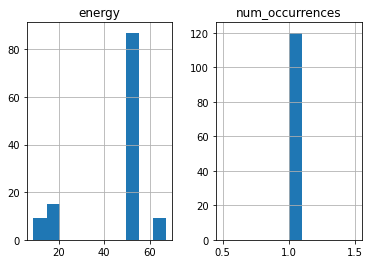

In [68]:
dataframe.hist()

<AxesSubplot:>

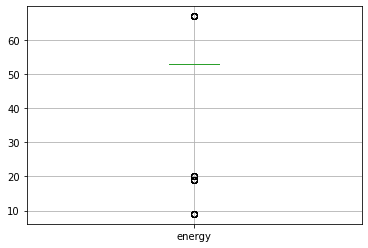

In [74]:
dataframe.boxplot('energy')